<h1>Counterfeit Banknote Detection Algorithm</h1>

<a href="https://openclassrooms.com/en/" >Openclassrooms</a>, Data Analyst Course
<br>Project 5 - Michael Orange

Objective of the course: **create an algorithm for detecting counterfeit banknotes**
<br>Algorithm based on banknotes characteristics:
- Length (in mm)
- Height measured in the left side (in mm)
- Height measured in the right side (in mm)
- Margin between superior side and the print (in mm)
- Margin between inferior side and the print (in mm)
- Diagonal (in mm)

<hr>

**Section 1** - [Exploratory Data Analysis](#explo)
- [Univariate Analysis](#uni)
- [Bivariate Analysis](#biv)
    - [Anova](#anova)
    - [Bravais-Pearson](#bravais)

**Section 2** - [PCA - Principal Component Analysis](#pca_title) 
- [Transform data](#transform)
- [Principal Component Analysis](#pca)
- [Number of components](#comp)
- [Synthetic variables](#synth)
- [Correlation Circles](#circle)
- [Individuals factor map](#map)
- [Centroids](#centroids)

**Section 3** - [K-means Clustering](#clustering)

**Section 4** - [Logistic regression - using Statsmodels](#stats) 
- [Logistic regression on scaled variables](#scaled)
    - [Train Logistic model regression](#train)
    - [Equation Logistic model regression](#equation)
    - [Model accuracy (score)](#score)   
    - [Test Model Predictions](#test)
    - [ROC-AUC classification metric](#roc-auc)
- [Logistic regression on pca synthetic variables](#synth_pca)
    - [Train Logistic model regression](#train_pca)
    - [Model accuracy (score)](#score_pca)   

**Section 5** - [Logistic regression - using Sklearn](#sk) 
- [Train Logistic model regression](#train_sk)
- [Model accuracy (score)](#score_sk)   
- [Test Model Predictions](#test_sk)
- [ROC-AUC classification metric](#roc-auc_sk)

<hr>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import pylab 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import math

import scipy.stats as stats

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.cluster import KMeans

import joblib

from display_functions import *
from display_pca import *

In [2]:
#import banknotes
notes = pd.read_csv("data/raw/notes.csv")

<hr>
<h2>Exploratory Data Analysis</h2><a id=explo'></a>

In [3]:
notes.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [4]:
#check for null values
notes.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

<hr>
<h3>Univariate Analysis</h3><a id='uni'></a>

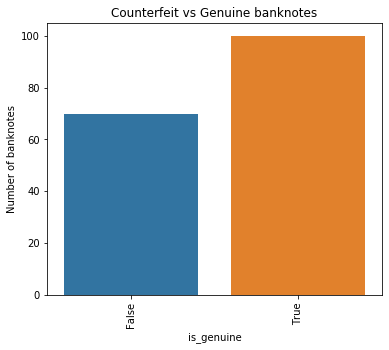

In [5]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.countplot(x='is_genuine', data=notes)
plt.title('Counterfeit vs Genuine banknotes')
plt.ylabel('Number of banknotes')
plt.xticks(rotation = 90)
plt.show()
fig.savefig('data/output_graphics/genuine', transparent=True)

<h4>Univariate analysis applied on genuine banknotes</h4>

In [6]:
# only genuine banknotes
genuine = notes.loc[notes['is_genuine'] == True]
genuine.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200
std,0.307981,0.296251,0.292406,0.314509,0.197726,0.380476
min,171.040000,103.230000,103.140000,3.540000,2.270000,111.760000
25%,171.790000,103.740000,103.557500,3.900000,2.937500,112.995000
50%,172.005000,103.915000,103.760000,4.080000,3.070000,113.210000
75%,172.162500,104.145000,103.972500,4.382500,3.192500,113.505000
max,172.750000,104.860000,104.950000,5.040000,3.530000,113.980000


In [7]:
# genuine with only numerical values
num_genuine = genuine.drop(['is_genuine'], axis=1)

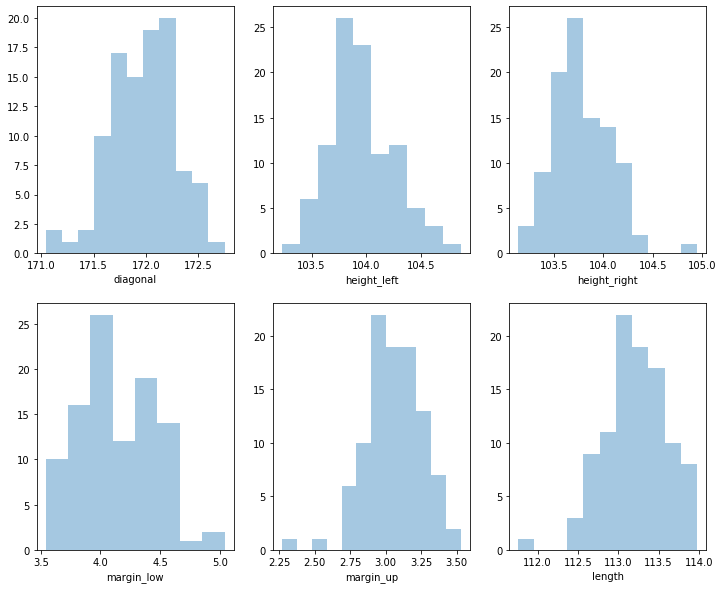

In [8]:
fig = display_multiple_distplot(num_genuine, [(2,3)], title='no')
fig.savefig('data/output_graphics/distplot', transparent =True)

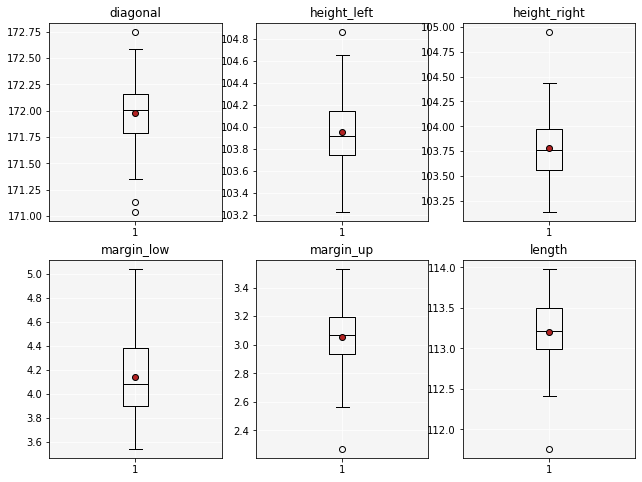

In [9]:
fig = display_multiple_boxplot(num_genuine, [(2,3)])
fig.savefig('data/output_graphics/boxplot', transparent =True)

<hr>
<h3>Bivariate Analysis</h3><a id='biv'></a>

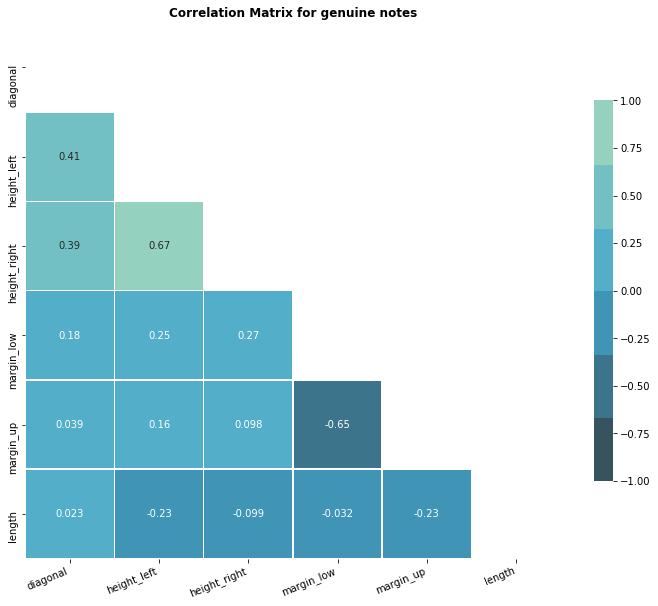

In [10]:
fig = display_corr_matrix(num_genuine, title='Correlation Matrix for genuine notes')
fig.savefig('data/output_graphics/corr_matrix_genuine', transparent=True)

In [11]:
#fig = sns.pairplot(notes, hue="is_genuine")
#fig.savefig('data/output_graphics/pairplot', transparent=True)

<h4>Bivariate Analysis - ANOVA </h4><a id='anova'></a>

Bivariate Analysis - between categorical variable 'is_genuine' and numerical variables

Hypothesis with Chi-2 test

    H0 : There is no correlation between  is_genuine and lenght
    H1 : There is a correlation between  is_genuine and lenght



In [12]:
num_notes = notes.drop(['is_genuine'], axis=1)
num_genuine = genuine.drop(['is_genuine'], axis=1)

In [13]:
significance = 0.05

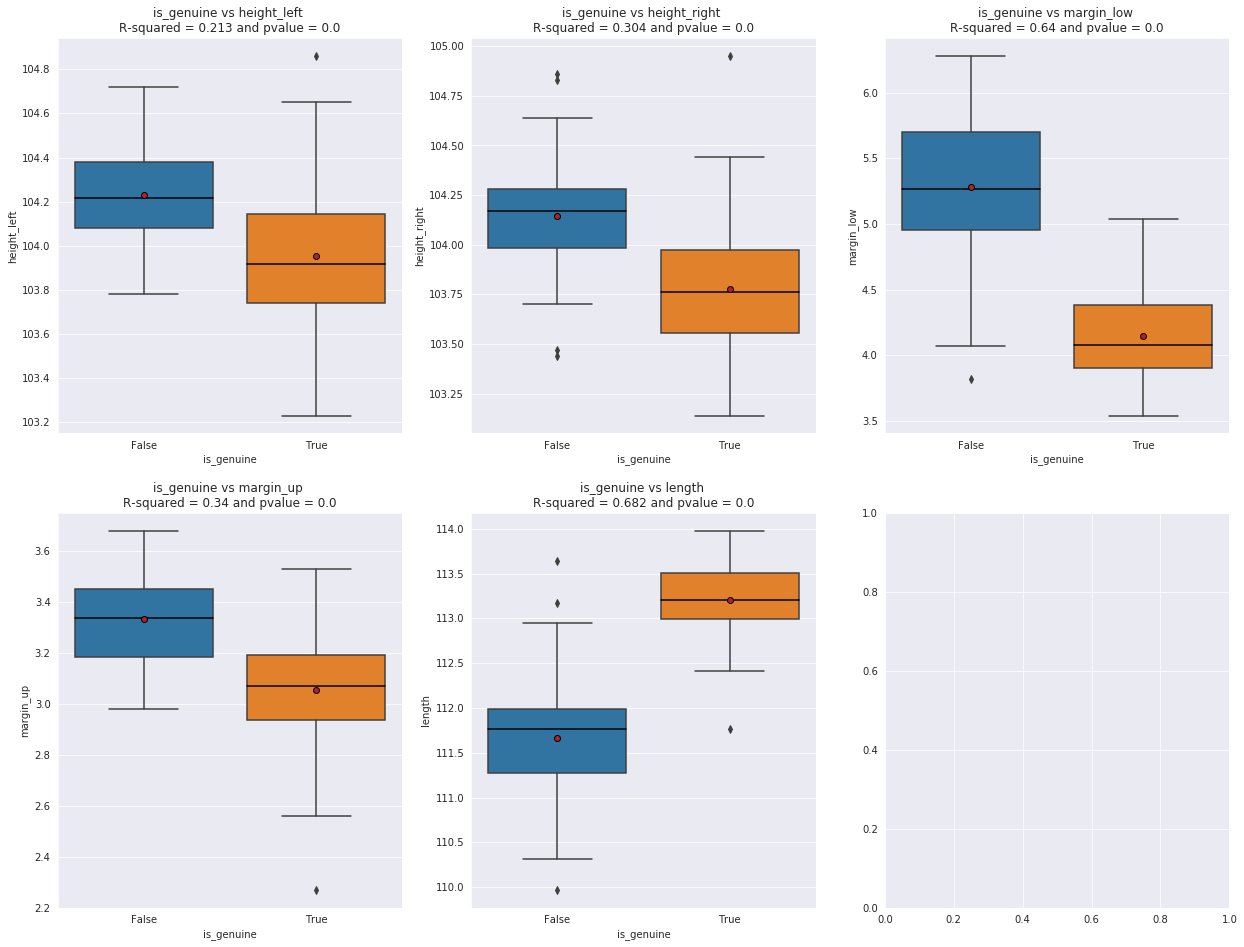

In [14]:
fig = display_multi_bivariate_boxplot('is_genuine', notes, [(2,3)], significance)
fig.savefig('data/output_graphics/biv_boxplot', transparent=True)

There is significant correlations between the genuine/counterfeit aspect of the banknotes and all other variables (except 'diagonal') at the signifance level of {{significance}}.
<br>The variables with the highest correlations are with:
- 'length'. The genuine/counterfeit aspect of the banknotes explained **68.2%** of the variation in the 'length'.
- 'margin_low'. The genuine/counterfeit aspect of the banknotes explained **64.0%** of the variation in the 'margin_low'.

<br>However the genuine/counterfeit aspect of the banknotes cannot entirely explain the variation of any of the variables.

<h4>Bivariate Analysis - Bravais-Pearson</h4><a id='bravais'></a>

Bivariate Analysis - Hypothesis:
- H0 : There is no correlation between the 2 variables.
- H1 : There is a correlation between the 2 variables.

In [15]:
significance = 0.05

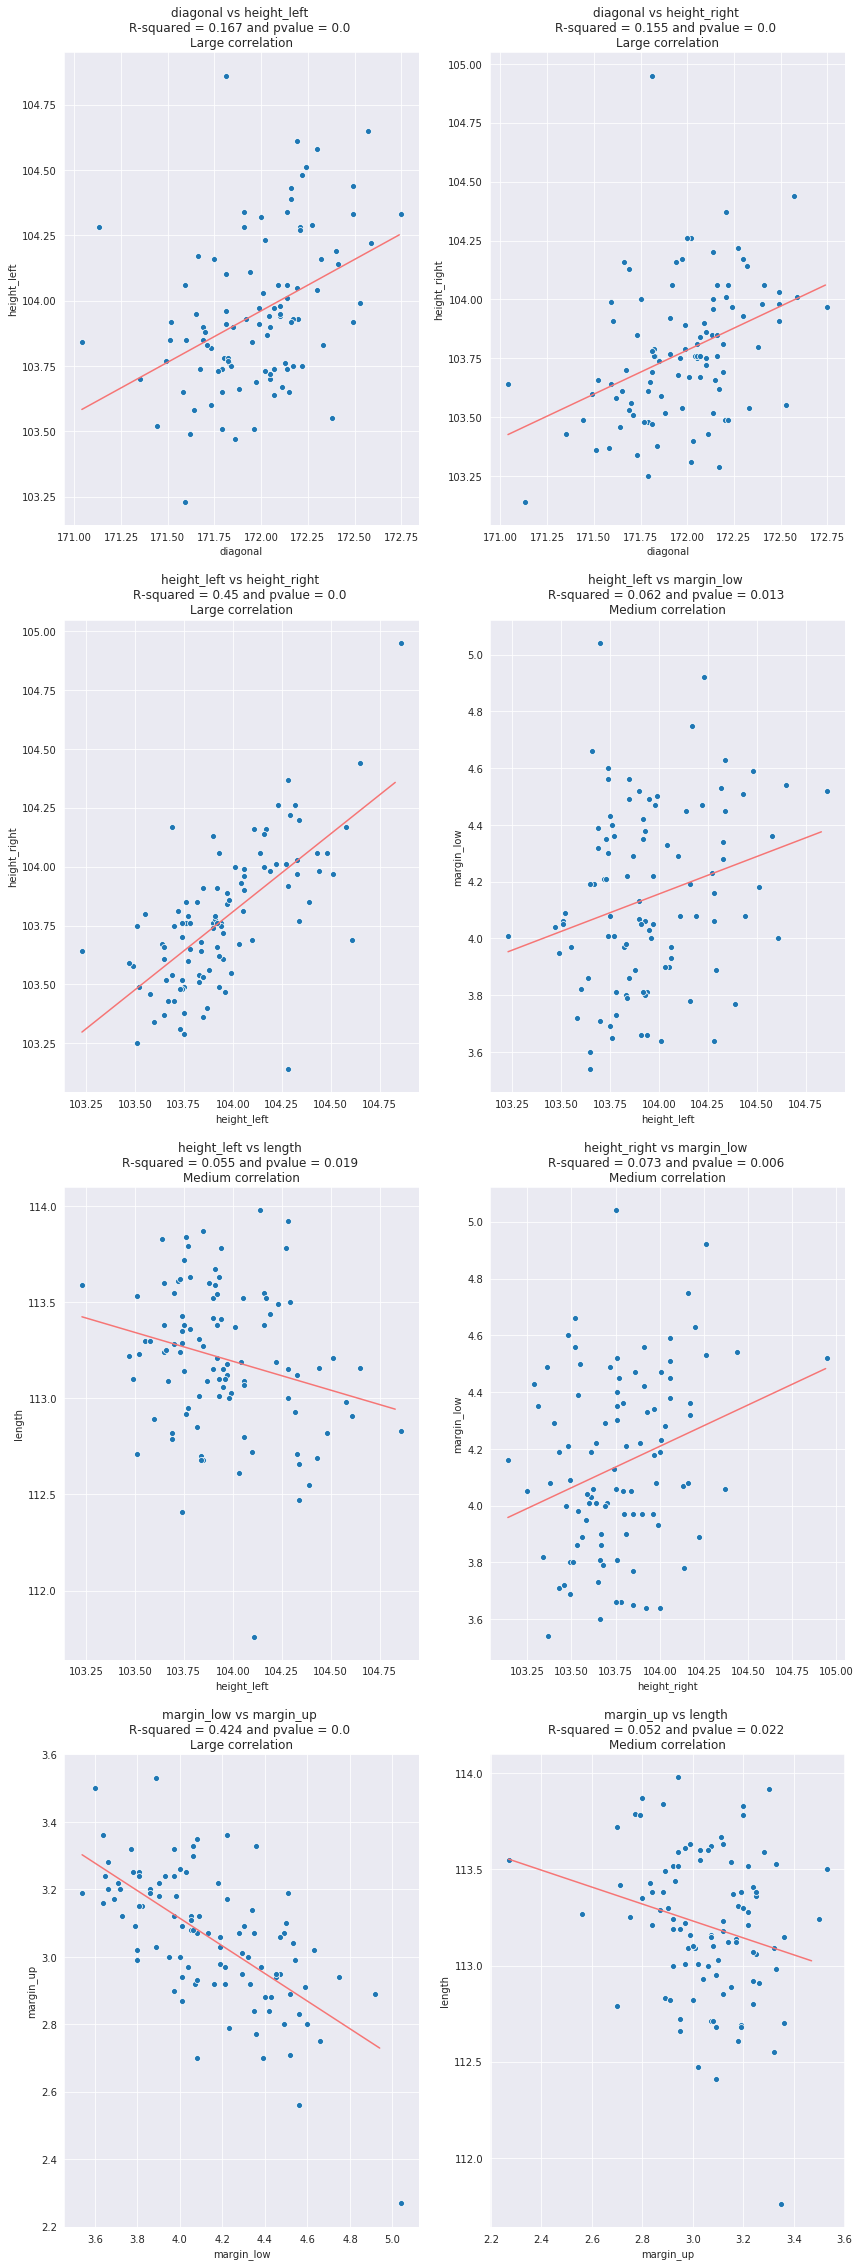

In [16]:
fig = display_multiple_scatter(num_genuine, [(4,2)], significance)
fig.savefig('data/output_graphics/biv_pearson', transparent=True)

There is a significant correlations between some of these numerical variables. Others have non significant correlations at the signifance level of {{significance}}.
<br>The variables with the highest correlations are:
- 'height_left' vs 'height_right'. 'height_left' explained **45.0%** of the variation in 'height_right'.
- 'margin_low' vs 'margin_up'. 'margin_low' explained **42.4%** of the variation in 'margin_up'.


<br>However none of the variable can entirely explain the variation of another variable. R-sqared are all under 45%.

<h4>Test of normality of the distributions</h4><a id='normal'></a>

The Shapiro-Wilk test evaluates variable's values and quantifies how likely it is that the data are from a Gaussian distribution.
- H0: Gaussian distribution
- H1: Not a Gaussian distribution



In [17]:
X_not_gaussian =[]
significance_level = 0.05
for X in num_notes.columns: 
    stat, pvalue = stats.shapiro(num_notes[X])
    if pvalue < significance_level:
        print('{}: --------Normal distribution not confirmed, H0 rejected with pvalue= {}'.format(X, pvalue))
        X_not_gaussian.append(X)

margin_low: --------Normal distribution not confirmed, H0 rejected with pvalue= 6.22572144948208e-07
length: --------Normal distribution not confirmed, H0 rejected with pvalue= 3.714224874329375e-07


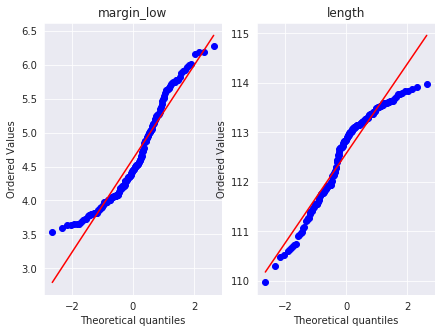

In [18]:
fig = display_multiple_henrylines(num_notes, X_not_gaussian, [(1,2)])
fig.savefig('data/output_graphics/henri_lines', transparent =True)

The gaussian (normal) distributions is still confirmed by the Henri lines for these 2 variables.

<hr>
<h2>Principal Component Analysis</h2><a id='pca_title'></a>

<h3>Transform data - mean centering and variance standardization</h3><a id='transform'></a>

In [19]:
num_notes

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78
166,173.01,104.59,104.31,5.04,3.05,110.91
167,172.47,104.27,104.10,4.88,3.33,110.68
168,171.82,103.97,103.88,4.73,3.55,111.87


In [20]:
X = num_notes.values
names = num_notes.index
features = num_notes.columns
print(X.shape)

(170, 6)


In [21]:
#number of observations
n = X.shape[0]
# number of variables
p = X.shape[1]

In [22]:
# Normalization (mean centering and variance standardization to 1)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

<h3>Principal Component Analysis</h3><a id='pca'></a>

In [23]:
# PCA
pca = decomposition.PCA(n_components=p)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<h3>Number of components</h3><a id='comp'></a>

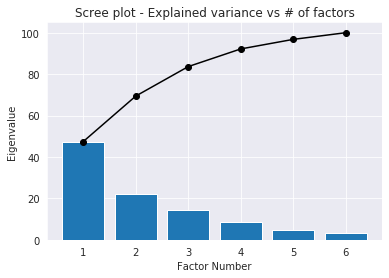

In [24]:
# Scree plot
fig = display_scree_plot(pca)
fig.savefig('data/output_graphics/scree_plot', transparent=True)

In [25]:
# number of component selected
n_comp = 3

In [26]:
# PCA
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [27]:
X_projected = pca.transform(X_scaled)

<h3>Synthetic variables</h3><a id='synth'></a>

In [28]:
# data frame with new synthetic variables
notes_X_projected = pd.DataFrame(X_projected, index=names, columns=['F'+str(i+1) for i in range(n_comp)])
notes_X_projected = pd.concat([notes_X_projected, notes[['is_genuine']]], axis=1)
notes_X_projected

,F1,F2,F3,is_genuine
0,2.153639,1.599709,1.787451,True
1,-2.110416,-0.526039,0.542563,True
2,-1.973152,-0.048102,0.858716,True
3,-2.059795,-0.089105,-0.531529,True
4,-2.403180,0.412170,3.319507,True
...,...,...,...,...
165,2.478626,0.189974,-0.814598,False
166,2.585331,2.914472,0.586789,False
167,2.067245,0.845602,-0.610282,False
168,0.739257,-0.972965,-1.359772,False


In [29]:
# composition of the synthetic variables
F_composition = {}
for k in range(n_comp):
    F_composition['F{}'.format(k+1)] = {}
    for n in range(p):
        F_composition['F{}'.format(k+1)].update({num_notes.columns[n]: pca.components_[k][n]})
pd.DataFrame(F_composition)

,F1,F2,F3
diagonal,0.073275,0.779639,-0.088894
height_left,0.475502,0.339250,0.122760
height_right,0.491821,0.235543,0.153830
margin_low,0.431027,-0.320537,0.512808
margin_up,0.352540,-0.141120,-0.821149
length,-0.465373,0.314536,0.126913


<h3>Correlation circles</h3><a id='circle'></a>

In [30]:
pcs = pca.components_

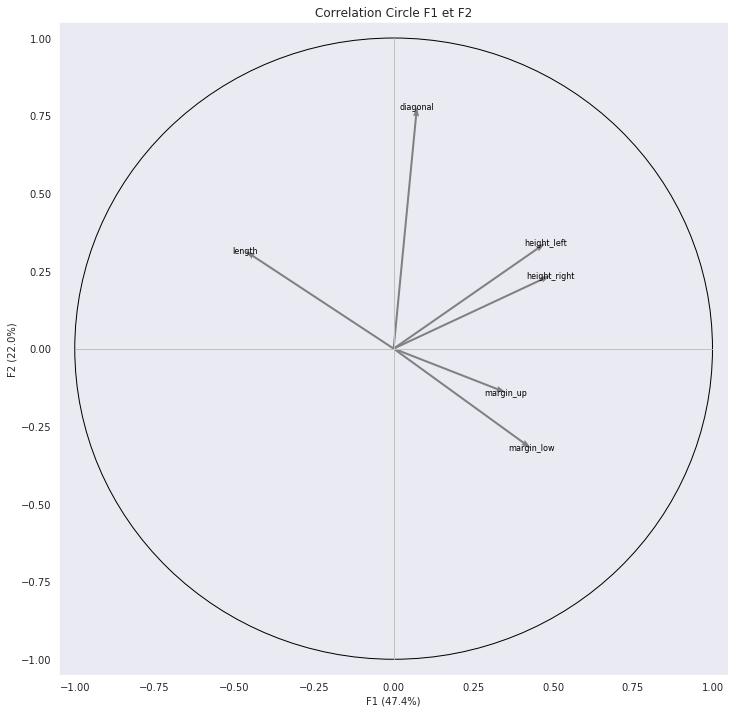

In [31]:
factors = [(0, 1)]
for d1, d2 in factors:
    
    fig = display_circles(pcs, n_comp, pca, factors, labels = np.array(features))
    fig.savefig('data/output_graphics/circleF{}F{}'.format(d1+1, d2+1))

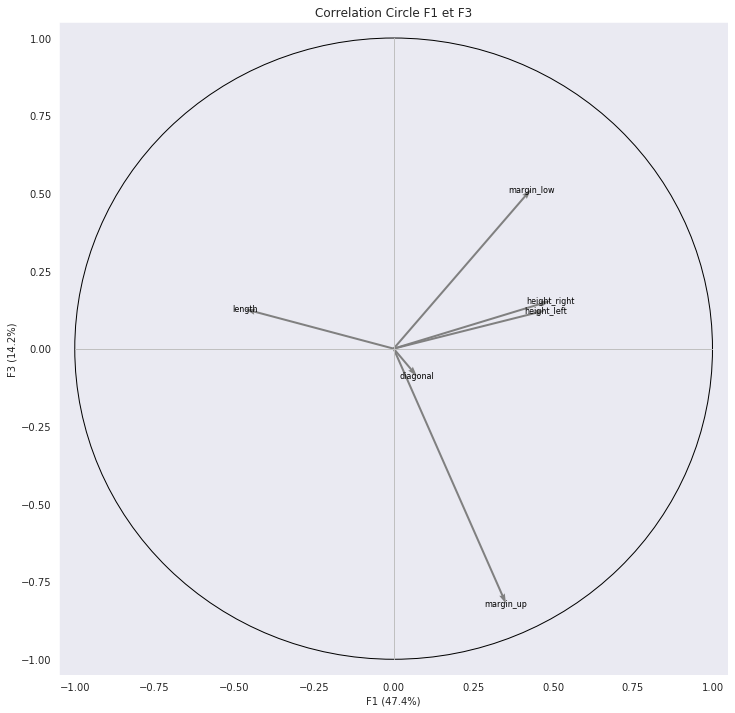

In [32]:
factors = [(0, 2)]
for d1, d2 in factors:
    
    fig = display_circles(pcs, n_comp, pca, factors, labels = np.array(features))
    fig.savefig('data/output_graphics/circleF{}F{}'.format(d1+1, d2+1))

<h3>Individuals factor map</h3><a id='map'></a>

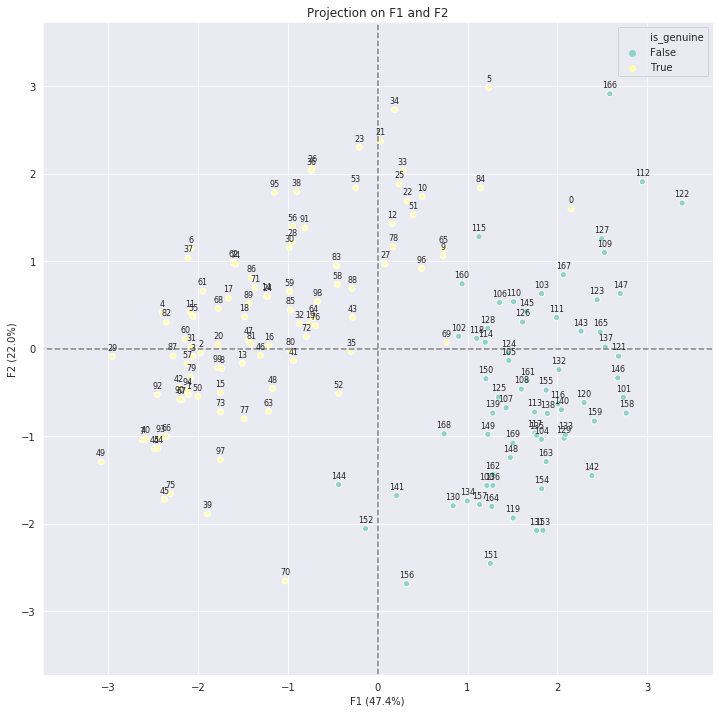

In [33]:
factors = [(0, 1)]
for d1, d2 in factors:
    
    fig1 = display_factorial_planes(X_projected, n_comp, pca, factors, labels=names, illustrative_var=notes['is_genuine'])
    fig1.savefig('data/output_graphics/projectionF{}F{}'.format(d1+1, d2+1))

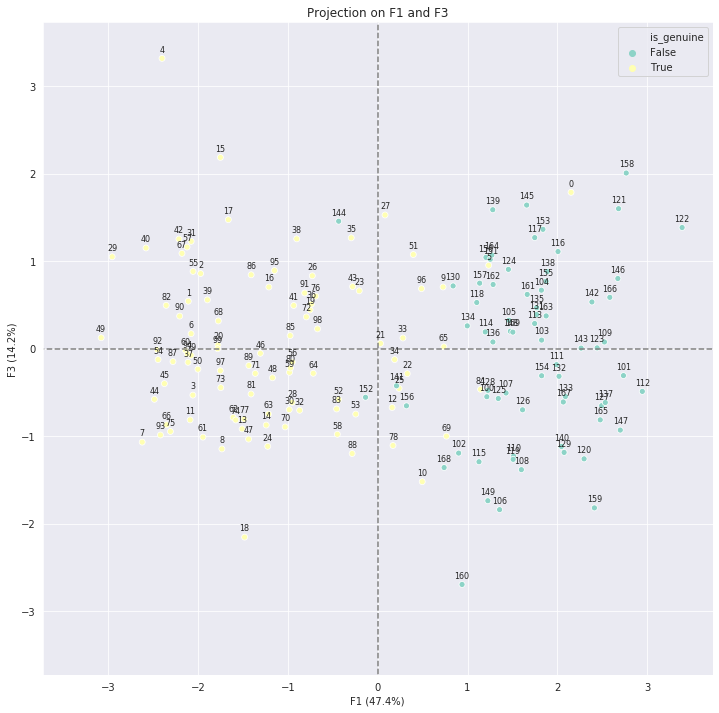

In [34]:
factors = [(0, 2)]
for d1, d2 in factors:
    
    fig1 = display_factorial_planes(X_projected, n_comp, pca, factors, labels=names, illustrative_var=notes['is_genuine'])
    fig1.savefig('data/output_graphics/projectionF{}F{}'.format(d1+1, d2+1))

**Individuals Contribution**

CTRα(i) = (Score de i sur l'axe α)^2 / (nλα)

In [35]:
notes_X_projected['contrib_F1'] = notes_X_projected['F1']**2 / (len(notes_X_projected) * pca.explained_variance_ratio_[0] * p)
notes_X_projected['contrib_F2'] = notes_X_projected['F2']**2 / (len(notes_X_projected) * pca.explained_variance_ratio_[1] * p)
notes_X_projected['contrib_F3'] = notes_X_projected['F3']**2 / (len(notes_X_projected) * pca.explained_variance_ratio_[2] * p)

**Individuals Quality**

QLTα(i) = (Score de i sur l'axe α)^2 / Sum (Score de i sur l'axe l)^2

In [36]:
num_notes['sum_squared'] = num_notes['diagonal']**2 + num_notes['height_left']**2 + num_notes['height_right']**2 + \
                                                    num_notes['margin_low']**2 + num_notes['length']**2 +  num_notes['margin_up']**2

In [37]:
notes_X_projected = notes_X_projected.merge(num_notes[['sum_squared']], left_index=True, right_index=True)

In [38]:
notes_X_projected['qual_F1'] = notes_X_projected['F1']**2 / notes_X_projected['sum_squared']
notes_X_projected['qual_F2'] = notes_X_projected['F2']**2 / notes_X_projected['sum_squared']
notes_X_projected['qual_F3'] = notes_X_projected['F2']**2 / notes_X_projected['sum_squared']

In [39]:
notes_X_projected['qual_F1F2'] = notes_X_projected['qual_F1'] + notes_X_projected['qual_F2']
notes_X_projected['qual_F1F3'] = notes_X_projected['qual_F1'] + notes_X_projected['qual_F3']

In [40]:
notes_X_projected

,F1,F2,F3,is_genuine,contrib_F1,contrib_F2,contrib_F3,sum_squared,qual_F1,qual_F2,qual_F3,qual_F1F2,qual_F1F3
0,2.153639,1.599709,1.787451,True,0.009584,0.011426,0.022005,64288.1896,0.000072,3.980623e-05,3.980623e-05,0.000112,0.000112
1,-2.110416,-0.526039,0.542563,True,0.009203,0.001236,0.002027,63845.2076,0.000070,4.334185e-06,4.334185e-06,0.000074,0.000074
2,-1.973152,-0.048102,0.858716,True,0.008045,0.000010,0.005079,64045.0241,0.000061,3.612742e-08,3.612742e-08,0.000061,0.000061
3,-2.059795,-0.089105,-0.531529,True,0.008767,0.000035,0.001946,63964.2751,0.000066,1.241277e-07,1.241277e-07,0.000066,0.000066
4,-2.403180,0.412170,3.319507,True,0.011933,0.000759,0.075893,64043.1120,0.000090,2.652649e-06,2.652649e-06,0.000093,0.000093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2.478626,0.189974,-0.814598,False,0.012694,0.000161,0.004570,63930.5899,0.000096,5.645179e-07,5.645179e-07,0.000097,0.000097
166,2.585331,2.914472,0.586789,False,0.013811,0.037927,0.002371,64087.8365,0.000104,1.325391e-04,1.325391e-04,0.000237,0.000237
167,2.067245,0.845602,-0.610282,False,0.008830,0.003193,0.002565,63739.9095,0.000067,1.121814e-05,1.121814e-05,0.000078,0.000078
168,0.739257,-0.972965,-1.359772,False,0.001129,0.004227,0.012735,63672.8000,0.000009,1.486757e-05,1.486757e-05,0.000023,0.000023


<h3>Centroids</h3><a id='centroids'></a>

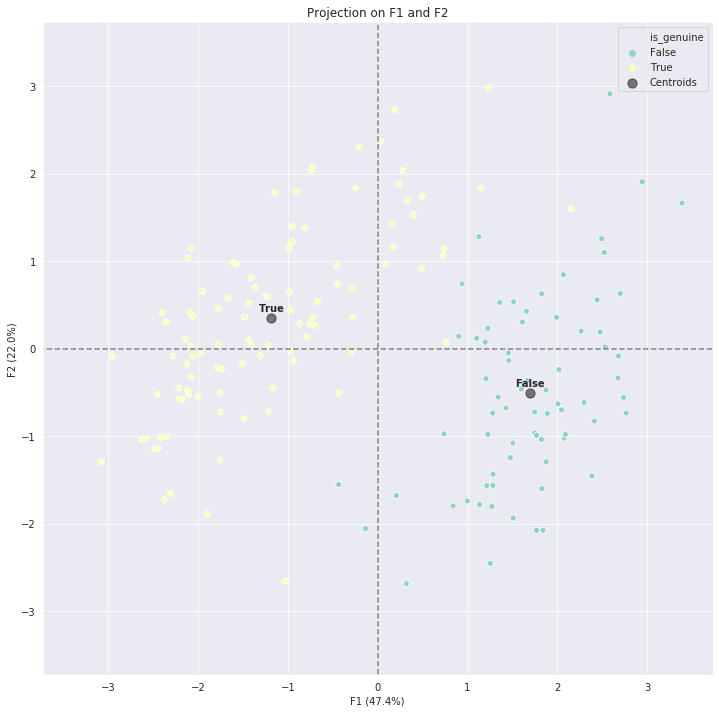

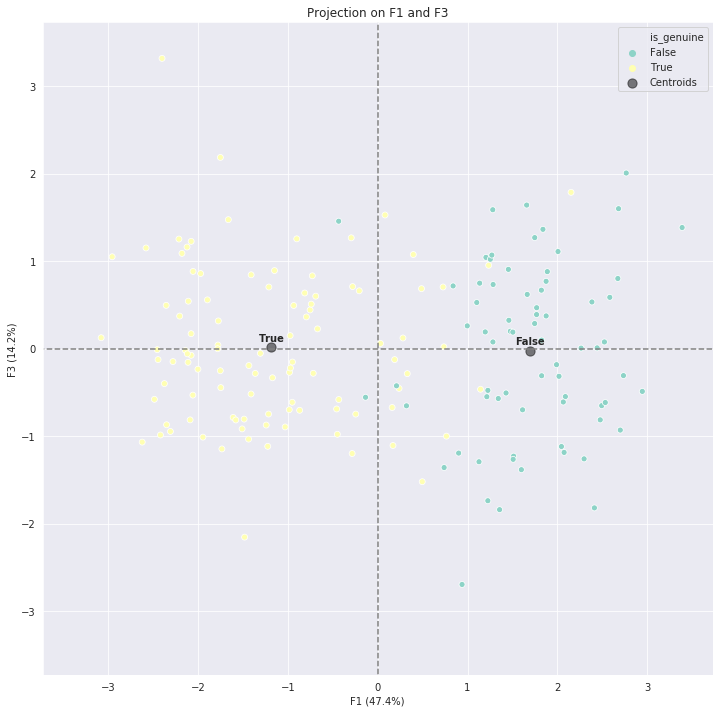

In [41]:
for d1, d2 in [(0, 1), (0,2)]:
    fig = display_factorial_planes(X_projected, n_comp, pca, [(d1, d2)], illustrative_var=notes['is_genuine'])
    fig.savefig('data/output_graphics/centroidsF{}F{}'.format(d1+1, d2+1))

**Centroids coordinates**

In [42]:
centroids_isgenuine = notes.pivot_table(index='is_genuine', values=notes.columns[1:], aggfunc=np.mean)
centroids_isgenuine

,diagonal,height_left,height_right,length,margin_low,margin_up
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,111.660714,5.281571,3.334571
True,171.976100,103.951500,103.775900,113.207200,4.143500,3.055500


<h2>K-means Clustering</h2><a id='clustering'></a>

In [43]:
num_clusters = 2

In [44]:
# Create a k-means clustering model
kmeans = KMeans(init='random', n_clusters=num_clusters, n_init=10)

# Fit the data to the model
kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to:
clusters =  kmeans.predict(X_scaled)

In [45]:
# Add cluster number to the original data
X = num_notes.drop('sum_squared', axis=1)
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

X_scaled_clustered.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,-0.428344,2.669454,3.096563,-0.131590,-1.189874,0.281633,1
1,-0.887559,-1.097697,-0.691254,-0.860126,-1.274740,0.780697,0
2,-0.362742,-1.030427,-0.509439,-0.303010,-1.232307,1.377405,0
3,-0.461145,-0.963156,-0.842767,-1.260106,-0.213913,1.149571,0
4,0.358883,-1.232238,-0.539742,0.611230,-3.820725,1.062777,0


In [46]:
X_scaled_clustered.reset_index().pivot_table(index='cluster', values='index', aggfunc=len)

,index
cluster,
0,94
1,76


In [47]:
notes_X_projected['cluster'] = clusters
notes_X_projected

,F1,F2,F3,is_genuine,contrib_F1,contrib_F2,contrib_F3,sum_squared,qual_F1,qual_F2,qual_F3,qual_F1F2,qual_F1F3,cluster
0,2.153639,1.599709,1.787451,True,0.009584,0.011426,0.022005,64288.1896,0.000072,3.980623e-05,3.980623e-05,0.000112,0.000112,1
1,-2.110416,-0.526039,0.542563,True,0.009203,0.001236,0.002027,63845.2076,0.000070,4.334185e-06,4.334185e-06,0.000074,0.000074,0
2,-1.973152,-0.048102,0.858716,True,0.008045,0.000010,0.005079,64045.0241,0.000061,3.612742e-08,3.612742e-08,0.000061,0.000061,0
3,-2.059795,-0.089105,-0.531529,True,0.008767,0.000035,0.001946,63964.2751,0.000066,1.241277e-07,1.241277e-07,0.000066,0.000066,0
4,-2.403180,0.412170,3.319507,True,0.011933,0.000759,0.075893,64043.1120,0.000090,2.652649e-06,2.652649e-06,0.000093,0.000093,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2.478626,0.189974,-0.814598,False,0.012694,0.000161,0.004570,63930.5899,0.000096,5.645179e-07,5.645179e-07,0.000097,0.000097,1
166,2.585331,2.914472,0.586789,False,0.013811,0.037927,0.002371,64087.8365,0.000104,1.325391e-04,1.325391e-04,0.000237,0.000237,1
167,2.067245,0.845602,-0.610282,False,0.008830,0.003193,0.002565,63739.9095,0.000067,1.121814e-05,1.121814e-05,0.000078,0.000078,1
168,0.739257,-0.972965,-1.359772,False,0.001129,0.004227,0.012735,63672.8000,0.000009,1.486757e-05,1.486757e-05,0.000023,0.000023,1


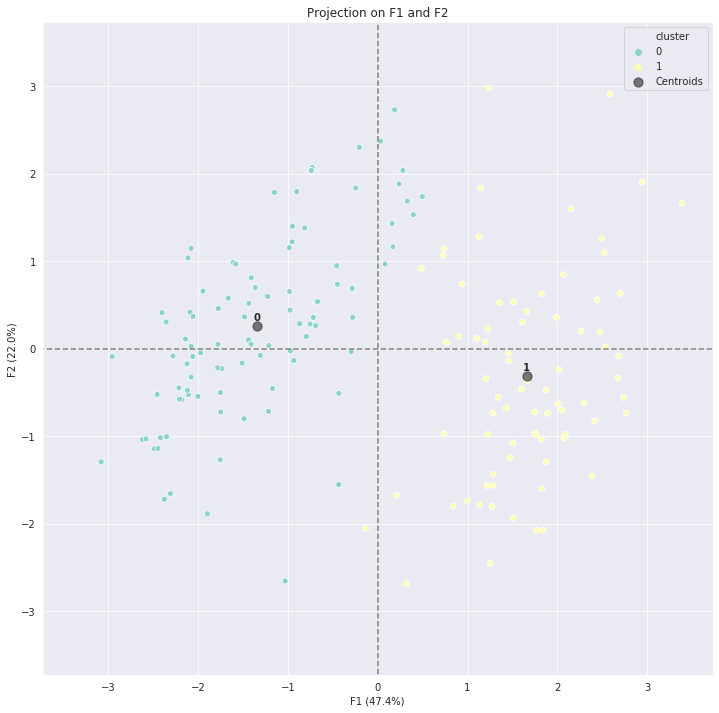

In [48]:
factors = [(0, 1)]
for d1, d2 in factors:
    
    fig = display_factorial_planes(X_projected, n_comp, pca, factors, illustrative_var=notes_X_projected.cluster)
    fig.savefig('data/output_graphics/projectionF{}F{} - Clusters'.format(d1+1, d2+1))

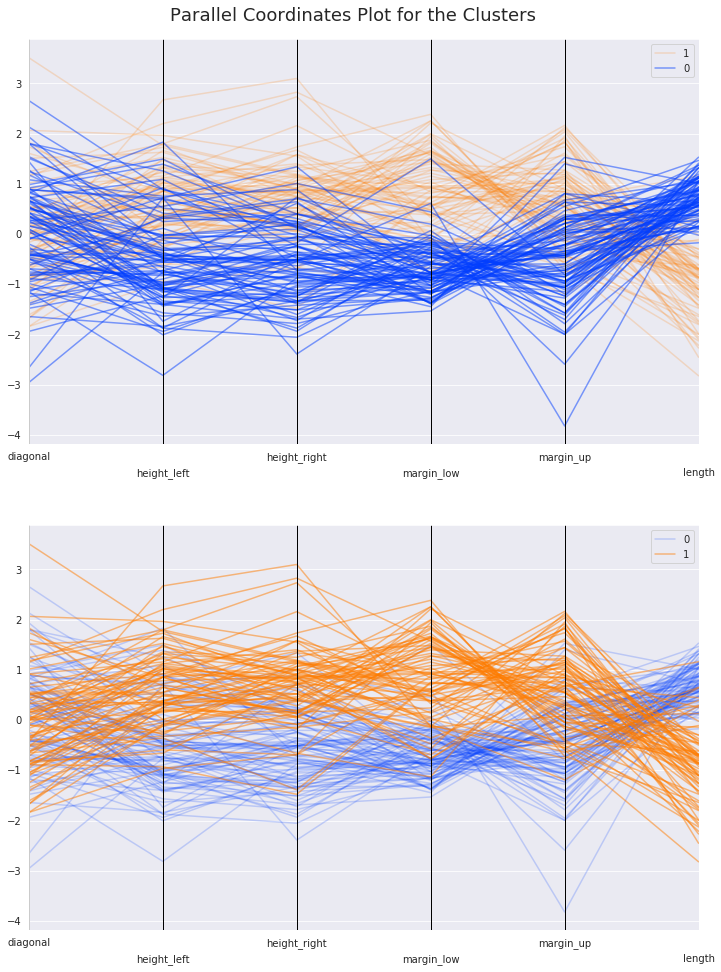

In [49]:
# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered["cluster"] = clusters

# Display parallel coordinates plots, one for each cluster
fig = display_parallel_coordinates(X_clustered, 2)
fig.savefig('data/output_graphics/parallel_coordinates', transparent=True)

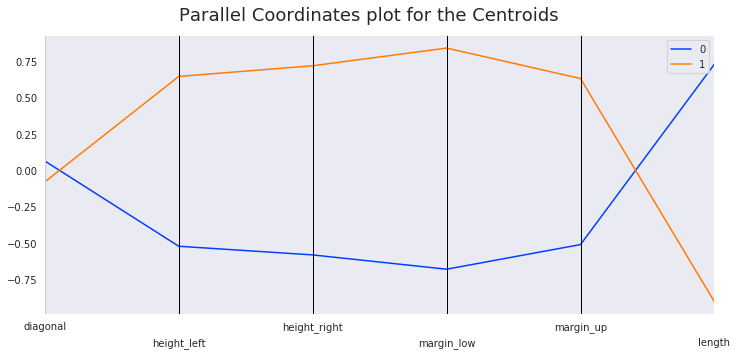

In [50]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

fig = display_parallel_coordinates_centroids(centroids, 10)
fig.savefig('data/output_graphics/parallel_coordinates_centroids', transparent=True)

**Centroids coordinates**

In [53]:
notes = notes.merge(X_scaled_clustered['cluster'], left_index=True, right_index=True)
centroids_cluster = notes.pivot_table(index='cluster', values=notes.columns[1:-1], aggfunc=np.mean)
centroids_cluster

,diagonal,height_left,height_right,length,margin_low,margin_up
cluster,,,,,,
0,171.960106,103.911277,103.736383,113.243085,4.136596,3.050213
1,171.916447,104.258158,104.165263,111.738421,5.200263,3.319079


<hr>
<h2>Logistic regression - using Statsmodels</h2><a id='stats'></a>

<h3>Logistic regression - using Statsmodels on scaled variables</h3><a id='scaled'></a>

In [54]:
X_scaled = pd.DataFrame(X_scaled.copy())
X_scaled.columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

In [55]:
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
target = 'is_genuine'
X = X_scaled[features]
y = notes[target]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [57]:
def backward_selection(endog, exog, alpha):
    model = sm.Logit(endog, exog)
    log_reg = model.fit(method='lbfgs')
    
    while any(log_reg.pvalues[k] > alpha for k in range(len(log_reg.pvalues))):
        exog = exog.copy()
        exog.drop(log_reg.pvalues.index[log_reg.pvalues == max(log_reg.pvalues)], axis=1, inplace=True)
        model = sm.Logit(endog, exog)
        log_reg = model.fit(method='lbfgs')
        
    conf_int = log_reg.conf_int().transpose()
    for k in conf_int.columns:
        if np.sign(conf_int[k][0]) != np.sign(conf_int[k][1]):
            exog.drop([k], axis=1, inplace=True)
            model = sm.Logit(endog, exog)
            log_reg = model.fit(method='lbfgs')
       
    print(log_reg.summary2())
        
    return log_reg

<h4>Train Logistic model regression</h4><a id='train'></a>

In [58]:
log_reg = backward_selection(y_train, X_train, 0.05)

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.954     
Dependent Variable: is_genuine       AIC:              12.5605   
Date:               2020-07-08 21:19 BIC:              18.3858   
No. Observations:   136              Log-Likelihood:   -4.2802   
Df Model:           1                LL-Null:          -92.139   
Df Residuals:       134              LLR p-value:      4.1727e-40
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     14.0000                                      
------------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025    0.975]
------------------------------------------------------------------
margin_low   -9.0096    3.6243  -2.4859  0.0129  -16.1131  -1.9061
length        7.5277    3.0038   2.5061  0.0122    1.6404  13.4151



<h4>Equation Logistic model regression</h4><a id='equation'></a>

In [59]:
Beta1 =  log_reg.params[0]
Beta2 = log_reg.params[1]

**logistic(x)**  =  1/ (1+ exp(−x))  =  exp(x) / (1+ exp(x))
<br>avec x =Beta1 * margin_low + Beta2 * length

In [60]:
#calculate x - just for illustration. Not required for .predict()
X_scaled['x'] =Beta1*X_scaled['margin_low'] + Beta2*X_scaled['length'] 

In [61]:
#calculate P (probability) - just for illustration. Not required for .predict()
X_scaled['P'] = 1 / (1 + np.exp( - X_scaled['x']))

In [62]:
odd_ratios = np.exp(log_reg.params)
odd_ratios

margin_low       0.000122
length        1858.856375
dtype: float64

<h4>Model accuracy (score)</h4><a id='score'></a>

In [63]:
score = log_reg.pred_table()
print('Test Accuracy Score', score)

Test Accuracy Score [[55.  1.]
 [ 1. 79.]]


In [64]:
score = (69+99)/(len(X))
print('Accuracy of the model', round(score, 4)*100, '%')

Accuracy of the model 98.82 %


<h3>Logistic regression - using Statsmodels on PCA synthetic variables</h3><a id='synth_pca'></a>

Apply logistic regression on PCA synthetic variables (F1, F2 and F3) instead of scaled-only variables. 
<br>Objective is to verify if the results are better throught the use of PCA factors. 

In [71]:
features = ['F1', 'F2', 'F3']
X_projected = pd.DataFrame(X_projected)
X_projected.columns = features

In [72]:
X = X_projected

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<h4>Train Logistic model regression</h4><a id='train_pca'></a>

In [74]:
log_reg_pca = backward_selection(y_train, X_train, 0.05)

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.848     
Dependent Variable: is_genuine       AIC:              32.0556   
Date:               2020-07-08 21:20 BIC:              37.8809   
No. Observations:   136              Log-Likelihood:   -14.028   
Df Model:           1                LL-Null:          -92.139   
Df Residuals:       134              LLR p-value:      7.5678e-36
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     10.0000                                      
--------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
--------------------------------------------------------------------
F1    -3.1539      0.6725    -4.6902    0.0000    -4.4719    -1.8360
F2     2.2678      0.6089     3.7247    0.0002     1.0745     3.4611



<h4>Model accuracy (score)</h4><a id='score_pca'></a>

In [75]:
score = log_reg_pca.pred_table()
print('Test Accuracy Score', score)

Test Accuracy Score [[56.  0.]
 [ 3. 77.]]


In [76]:
score = (70+97)/(len(X))
print('Accuracy of the model', score)

Accuracy of the model 0.9823529411764705


Using the PCA synthetic variables do not improve the model. The accuracy is even slightly lower. 
<br>Therefore the selected model is the one using the scaled variables. It offers better results and it is less restrictive (only 2 variables are required). 

<h2>Logistic regression - using Sklearn on scaled variables</h2><a id='sk'></a>

In [77]:
features = ['margin_low', 'length']
X = X_scaled[features]
y = y

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<h4>Train Logistic model regression</h4><a id='train_sk'></a>

In [79]:
log_reg_sk = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

In [80]:
values = log_reg_sk.coef_
names = X_train.columns

display_results = pd.DataFrame(values, columns=names).transpose()
display_results.columns = ['coef']

In [81]:
display_results['odd_ratios'] = np.exp(display_results['coef'])
display_results

,coef,odd_ratios
margin_low,-2.467198,0.084822
length,2.492487,12.091307


For every one unit increase of the length, the odds of the banknote to be True increases by 12 times.

<h4>Model accuracy (score)</h4><a id='scrore_sk'></a>

In [82]:
#cross-validation
kfold = KFold(5, True, 1)
results = cross_val_score(log_reg_sk, X, y, cv=kfold)
print(results)
score = results.mean()
print('Accuracy of the model (Kfold):', round(results.mean(),3)*100, '%')

[0.94117647 1.         1.         0.97058824 1.        ]
Accuracy of the model (Kfold): 98.2 %


<h4>Test Model Predictions</h4><a id='test_sk'></a>

In [83]:
y_predict = log_reg_sk.predict(X_test)

In [84]:
# Test on the test dataset
print(dict(zip(X_test.index, y_predict)))

{133: False, 136: False, 168: False, 54: True, 56: True, 144: False, 7: True, 96: True, 121: False, 97: True, 141: False, 5: True, 83: True, 109: False, 55: True, 18: True, 61: True, 101: False, 60: True, 63: True, 153: False, 4: True, 106: False, 161: False, 108: False, 37: True, 66: True, 157: False, 45: True, 26: True, 33: True, 125: False, 44: True, 8: True}


In [85]:
results = X_test.copy()

results['predict_genuine'] = y_predict
results['prob_genuine'] = log_reg_sk.predict_proba(X_test)[:,1]

<h5>Confusion matrix</h5>

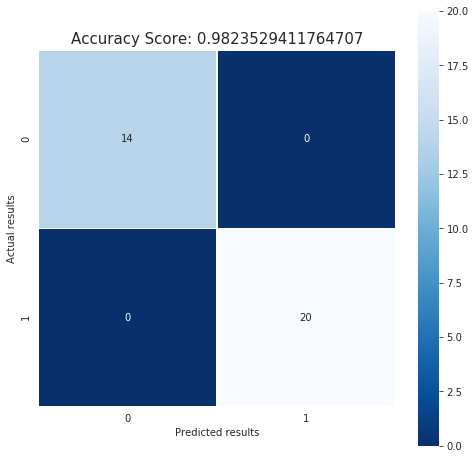

In [86]:
cm = metrics.confusion_matrix(y_test, y_predict)

fig = plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual results');
plt.xlabel('Predicted results');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
fig.savefig('data/output_graphics/confusionmatrix', transparent=True)

<h4>ROC-AUC classification metric</h4><a id='roc_auc_sk'></a>

Not required for this dataset because data are well balanced between positive and negatives. 

In [87]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)

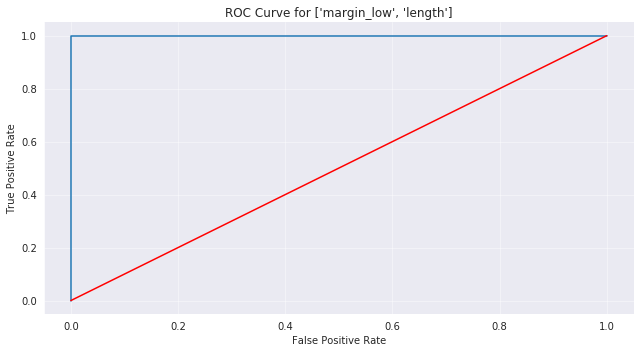

In [88]:
fig, ax = plt.subplots(1,1, figsize = (9,5))
plt.plot(false_positive_rate, true_positive_rate, label = '')
plt.plot([0,1],[0,1],color='red',linestyle='-')
plt.title('ROC Curve for {}'.format(features))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(alpha = 0.5)
sns.despine()
plt.tight_layout()
fig.savefig('data/output_graphics/roc', transparent=True)

In [89]:
roc_auc_score(y_test, y_predict)

1.0

<h2>Export model</h2>

In [90]:
joblib.dump(log_reg_sk, 'models/log_reg.model')

['models/log_reg.model']

In [91]:
joblib.dump(std_scale , 'models/std_scale.model')

['models/std_scale.model']